<a href="https://colab.research.google.com/github/JYJJEON/AIFFEL_Online_Quest/blob/main/Mainquest04/Mainquest04(Chest_Xray).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 캐글에서 코랩으로 데이터 저장

In [ ]:
# 코랩 셀에 아래 코드 입력
!pip install kaggle --upgrade

In [ ]:
from google.colab import files
files.upload()

In [11]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

In [ ]:
!unzip chest-xray-pneumonia.zip

# Train, Val, Test 파일 지정

In [14]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action='ignore')

In [15]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join('/content/')
TRAIN_PATH = ROOT_PATH + '/chest_xray/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 16
EPOCHS = 10

print(ROOT_PATH)


/content/


In [16]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


In [17]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


In [18]:
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/content//chest_xray/train/NORMAL/NORMAL2-IM-1187-0001.jpeg
Pneumonia image path
/content//chest_xray/train/PNEUMONIA/person5_bacteria_15.jpeg


In [19]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1070
Pneumonia images count in training set: 3115


In [20]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [21]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


In [22]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

In [23]:
# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

In [24]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [25]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


In [26]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


# 좌우를 랜덤하게 반전시켜 데이터 증강
- x ray 특성상 찍는 방향이 일정하고 사람들의 폐 모양은 비슷하여 다른 이미지 변화를 주면 리스크가 존재할 것으로 판단된다.

추가적으로 시도해 보고 싶은 사항:

1. ±15° rotation.
2. ±15% x-axis shift.
3. ±15% y-axis shift.
4. Horizontal flipping.
5. 85 –115% scaling.
6. Shear transformation (assuming a certain range, e.g., ±15°).
7. Mixup with a parameter set to 0.1.

출처: Zhang R, Tie X, Qi Z, Bevins NB, Zhang C, Griner D, et al. Diagnosis of covid-19 pneumonia using chest radiography: value of artificial intelligence. Radiology. (2020) 298:202944. doi: 10.1148/radiol.2020202944

단순하면서도 좋은 효과를 거둔것으로 확인 됨








In [27]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    return image,label

In [28]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

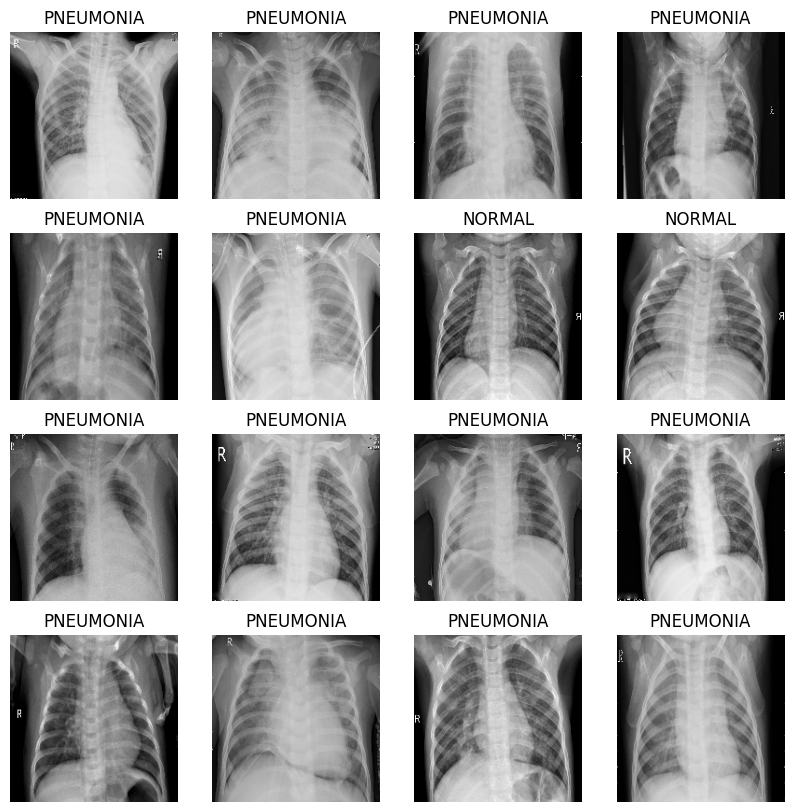

In [29]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

# ResNet 18을 위한 residual_block 지정
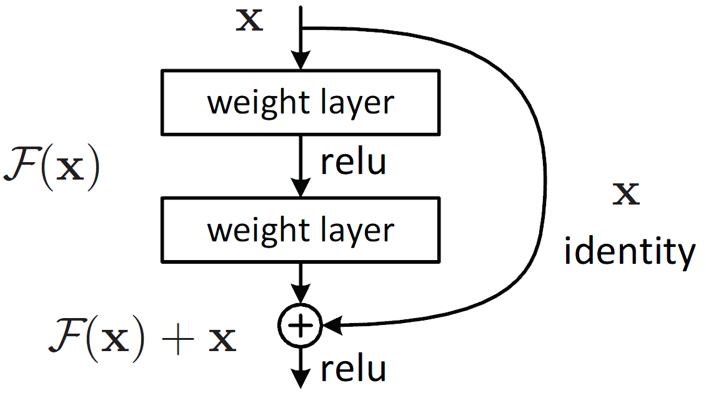
- 첫번째 convolution layer에서는 batch normalization과 activation 모두 통과시키나 두번째는convolution layer는 통과시키고 batch normalization 시킨 후 input을 더해준 값을 activation 시켜준다.

In [30]:
def residual_block(x, filters, kernel_size=3, stride=1, conv_shortcut=True):

    # Shortcut
    if conv_shortcut:
        shortcut = Conv2D(filters, 1, strides=stride,padding ='same')(x)
        shortcut = BatchNormalization()(shortcut)
    else:
        shortcut = x

    # First convolution
    x = Conv2D(filters, kernel_size, strides=stride, padding="same")(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    # Second convolution
    x = Conv2D(filters, kernel_size, padding="same")(x)
    x = BatchNormalization()(x)

    # Adding the shortcut to the output
    x = Add()([shortcut, x])
    x = ReLU()(x)

    return x

기존의 ResNet 18 의 경우 image class가 여러개여서 마지막 dense layer에 softmax activation layer가 있지만 위의 경우 True ,False 이기 때문에 sigmoid 함수를 적용

In [36]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, ReLU, Add, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
def ResNet18():

    inputs = Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))

    # Initial convolution
    x = Conv2D(64, 7, strides=2, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = tf.keras.layers.MaxPooling2D(3, strides=2, padding="same")(x)

    # Residual blocks
    x = residual_block(x, 64, stride=1)
    x = residual_block(x, 64, stride=1, conv_shortcut=False)

    x = residual_block(x, 128, stride=2)
    x = residual_block(x, 128, stride=1, conv_shortcut=False)

    x = residual_block(x, 256, stride=2)
    x = residual_block(x, 256, stride=1, conv_shortcut=False)

    x = residual_block(x, 512, stride=2)
    x = residual_block(x, 512, stride=1, conv_shortcut=False)

    # Global average pooling
    x = GlobalAveragePooling2D()(x)

    # Fully connected layer
    outputs = Dense(1, activation='sigmoid')(x)

    return Model(inputs=inputs, outputs=outputs)

In [37]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.96
Weight for PNEUMONIA: 0.67


In [38]:
with tf.device('/GPU:0'):
    model = ResNet18()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

epoch수를 증가 시킨 후 model check point를 통해 best 값만 저장

In [45]:
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint('Best.h5',
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True,
                             mode='auto'
                            )
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=50,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
        callbacks = [checkpoint]
    )

Epoch 1/50
261/261 [==============================] - ETA: 0s - loss: 0.0701 - accuracy: 0.9705 - precision: 0.9927 - recall: 0.9675
Epoch 1: val_loss improved from inf to 16.90011, saving model to Best.h5
261/261 [==============================] - 54s 181ms/step - loss: 0.0701 - accuracy: 0.9705 - precision: 0.9927 - recall: 0.9675 - val_loss: 16.9001 - val_accuracy: 0.2692 - val_precision: 1.0000 - val_recall: 0.0013
Epoch 2/50
261/261 [==============================] - ETA: 0s - loss: 0.0594 - accuracy: 0.9756 - precision: 0.9931 - recall: 0.9739
Epoch 2: val_loss improved from 16.90011 to 0.08995, saving model to Best.h5
261/261 [==============================] - 54s 207ms/step - loss: 0.0594 - accuracy: 0.9756 - precision: 0.9931 - recall: 0.9739 - val_loss: 0.0899 - val_accuracy: 0.9654 - val_precision: 0.9619 - val_recall: 0.9921
Epoch 3/50
261/261 [==============================] - ETA: 0s - loss: 0.0615 - accuracy: 0.9758 - precision: 0.9938 - recall: 0.9736
Epoch 3: val_loss 

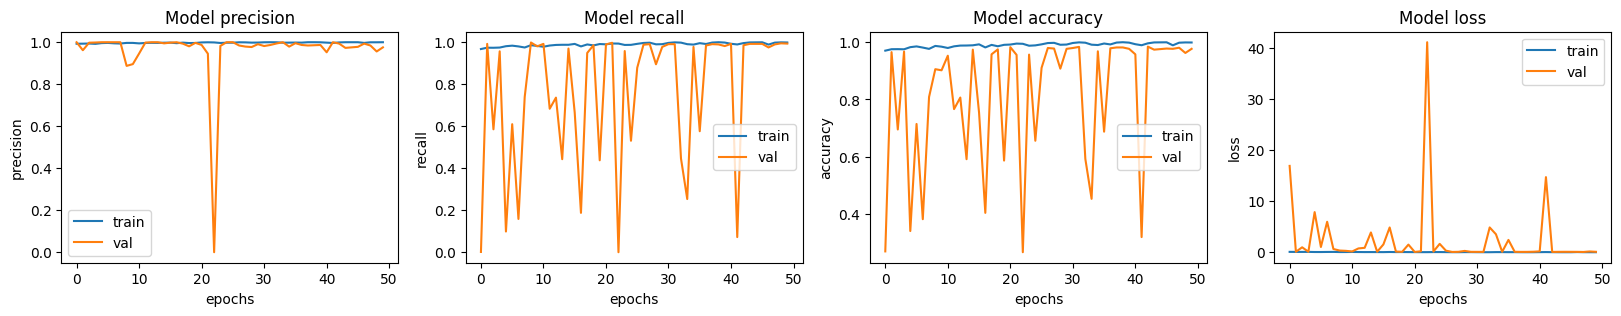

In [46]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [47]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 4s 87ms/step - loss: 2.8302 - accuracy: 0.7212 - precision: 0.6915 - recall: 1.0000
Loss: 2.830153226852417,
Accuracy: 0.7211538553237915,
Precision: 0.6914893388748169,
Recall: 1.0
